# W.6. Currency

## Financial Analytics

### UChicago ADSP

#### Spring 2024

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *
#from portfolio import *

$$\newcommand{\frn}{*}$$

$$\newcommand{\RF}{R^{f,\$}}$$
$$\newcommand{\RFa}{R^{f,\frn}}$$

$$\newcommand{\rflog}{\texttt{r}^{f,\$}}$$
$$\newcommand{\rfalog}{\texttt{r}^{f,\frn}}$$

$$\newcommand{\Fcrncy}{F^{\$}}$$
$$\newcommand{\fcrncylog}{\texttt{f}^{\$}}$$

$$\newcommand{\FX}{S}$$
$$\newcommand{\fxlog}{\texttt{s}}$$

## Currency

Currency is traded on the **spot** market at the **exchange rate**.

## Derivatives

Currency derivatives include, (in descending order of size/importance)
* forwards
* swaps
* futures
* options

A few notes on the sizes here...
* Forward currency market is larger than interest-rate forwards!
* Swaps market for currency is about 10% the size of interest-rate swaps.
* Currency options are relatively small, yet still about 1/3 the size of equity options!

### Notable Features
* FX markets are smaller than rates markets, but still huge.
* FX trades mostly in spot, forwards, and swaps
* Relatively small amount in options or futures

### References
OTC Derivatives Size

https://stats.bis.org/statx/srs/table/d5.1

Futures Markets Size

https://stats.bis.org/statx/srs/table/d1

Trading Turnover

https://stats.bis.org/statx/srs/table/d11.1

## Data

`fx_carry_data.xlsx`.

## Risk-free rates
It reports the risk-free rates for various currencies.
- Uses LIBOR, which is being phased out, but is still in-use and easy to get the data from the Fed site, **FRED**.

Timing of the risk-free rate
- The data is defined such that the March value of the risk-free rate corresponds to the rate beginning in March and ending in April.
- In terms of the class notation, $r^{f,i}_{t,t+1}$ is reported at time $t$. (It is risk-free, so it is a rate from $t$ to $t+1$ but it is know at $t$.

## Exchange rates
Spot exchange rates.

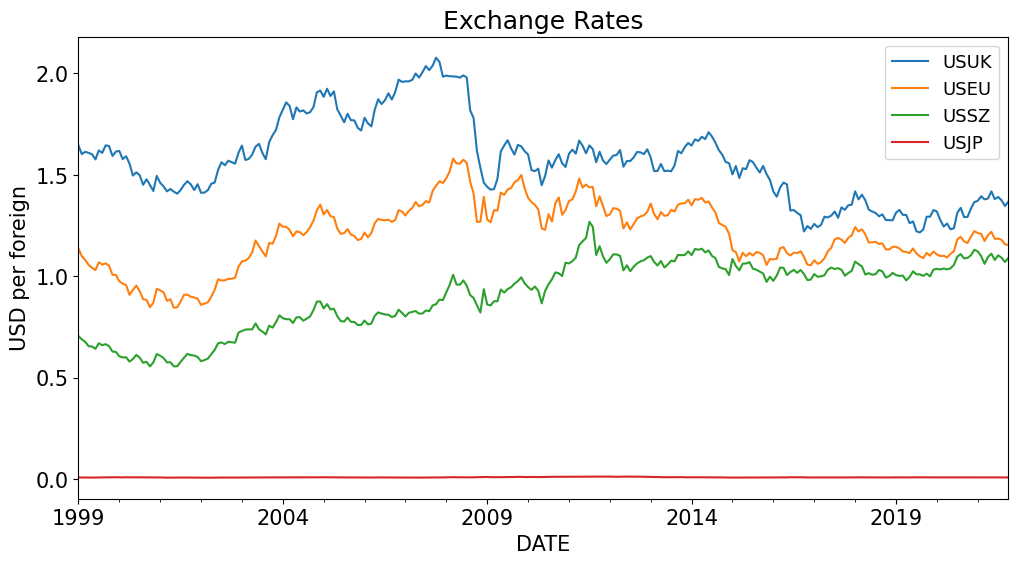

In [2]:
DATAPATH_FX = '../data/fx_carry_data.xlsx'
SHEET = 'fx rates'

fx = pd.read_excel(DATAPATH_FX, sheet_name=SHEET).set_index('DATE')
fx.plot(title='Exchange Rates',ylabel='USD per foreign');

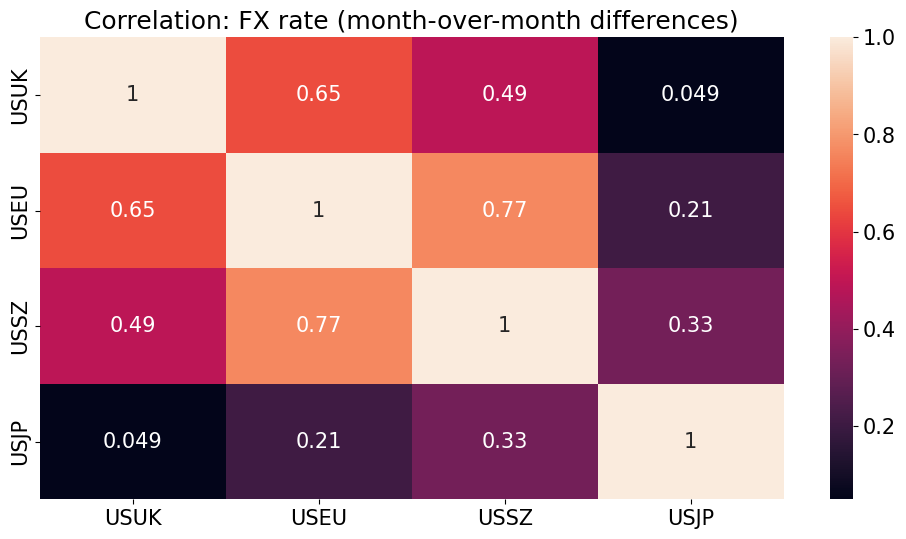

In [3]:
sns.heatmap(fx.diff().corr(),annot=True)
plt.title('Correlation: FX rate (month-over-month differences)');

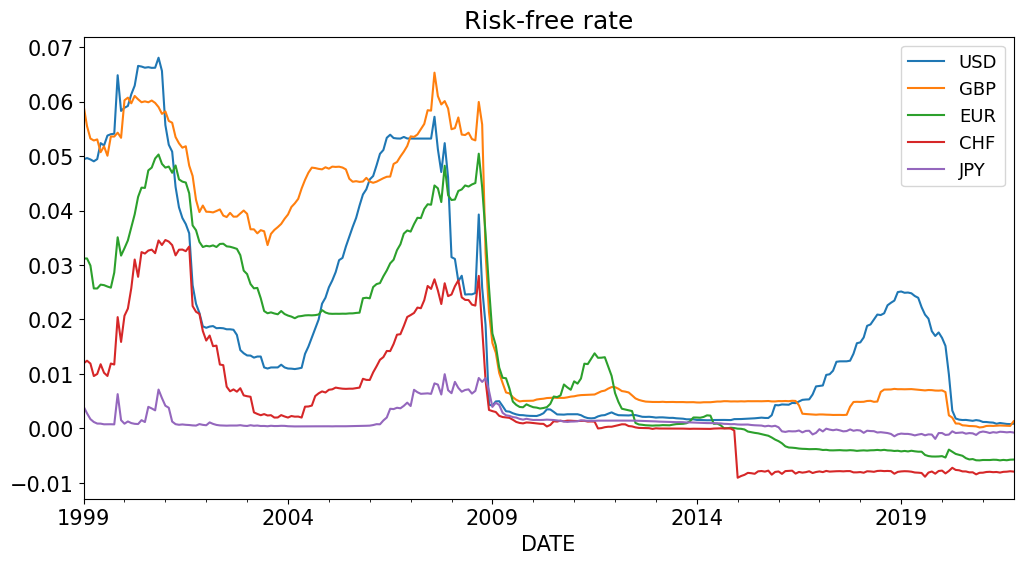

In [4]:
SHEET = 'risk-free rates'

rfraw = pd.read_excel(DATAPATH_FX,sheet_name=SHEET).set_index('DATE')
rfraw.columns = [col.removesuffix('1M') for col in rfraw.columns]

(rfraw * 12).plot(title='Risk-free rate');

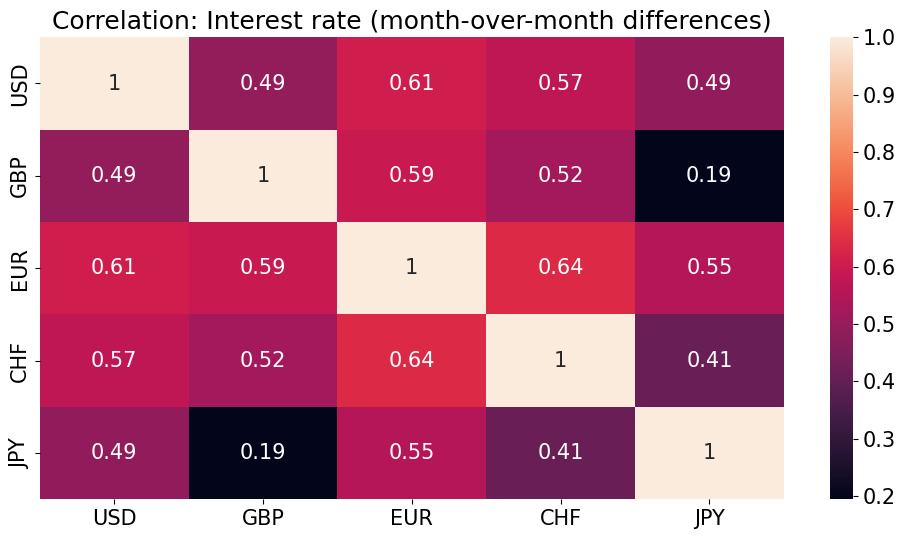

In [5]:
sns.heatmap(rfraw.diff().corr(),annot=True)
plt.title('Correlation: Interest rate (month-over-month differences)');

## Returns

### Notation

* $S_t$ denotes the foreign exchange rate, expressed as USD per foreign currency
* $\RF_{t,t+1}$ denotes the risk-free factor on US dollars (USD).
* $\RFa_{t,t+1}$ denotes the risk-free factor on a particular foreign currency.

### Two components to returns

Misconception that the return on currency is the percentage change in the exchange rate:
$$\frac{S_{t+1}}{S_t}$$

The price of the currency is $S_t$ dollars.
* In terms of USD, the payoff at time t + 1 of the Euro riskless asset is 
$$\RFa_{t,t+1} S_{t+1}$$

That is, 
* we capitalize any FX gains, 
* but we also earn the riskless return accumulated by the foreign currency.

Thus, the USD return on holding Euros is given by,
$$\RFa_{t,t+1}\frac{ S_{t+1}}{S_t}$$

In [6]:
USDRF = 'USD'

rfusd = rfraw[[USDRF]]
rf = rfraw.drop(columns=[USDRF])

fxgrowth = (fx / fx.shift())
rets = fxgrowth.mul(1+rf.values,axis=1) - 1
rx = rets.sub(rfusd.values,axis=1)

In [7]:
rets.loc['2018-04-01':,:].mean()

USUK    0.000004
USEU   -0.001756
USSZ    0.000420
USJP   -0.001623
dtype: float64

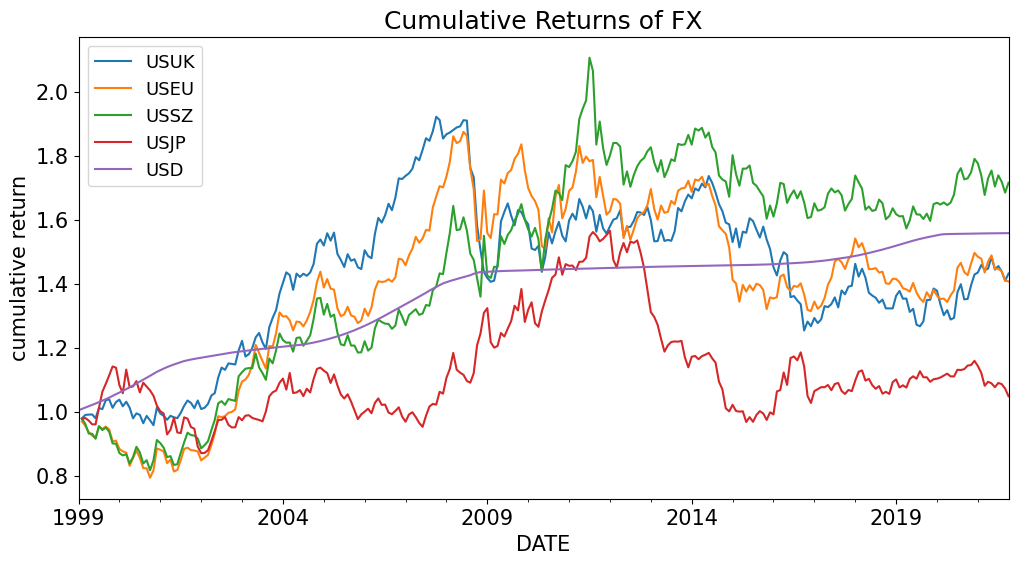

In [8]:
fig, ax = plt.subplots()
(1+rets).cumprod().plot(ax=ax)
(1+rfusd).cumprod().plot(ax=ax)
plt.title('Cumulative Returns of FX')
plt.ylabel('cumulative return')
plt.show()

### Extra Statistics on Returns

Main takeaway:
* small mean return--only exciting if you use leverage
* substantial volatility
* large drawdowns (tail-events)

## Decomposing the Returns

Using logs, we can split out the two components of excess log returns

### Logarithms
The data is mostly analyzed in logs, as this simplifies equations later.
* For monthly rates, logs vs levels won't make a big difference.

### Excess returns

The (USD) return in excess of the (USD) risk-free rate is then

$$\tilde{r}^i_{t+1} \equiv \fxlog^i_{t+1} - \fxlog^i_t + r^{f,i}_{t,t+1} - r^{f,\$}_{t,t+1}$$

### Two spreads
For convenience, rewrite this as

$$\tilde{r}^i_{t+1} \equiv \left(\fxlog^i_{t+1} - \fxlog^i_t\right) + (\rfalog_{t,t+1} - \rflog_{t,t+1})$$


#### Data Consideration
1. Build the spread in risk-free rates: 

$$\rflog_{t,t+1} - \rfalog_{t,t+1}$$.

* Lag this variable, so that the March-to-April value is stamped as April.

2. Build the FX growth rates: 

$$ \fxlog^i_{t+1} - \fxlog^i_t$$

* These are already stamped as April for the March-to-April FX growth.

Then the excess log return is simply the difference of the two objects.

In [9]:
logFX = np.log(fx)
logRFraw = np.log(rfraw+1)
logRFusd = logRFraw[[USDRF]]
logRF = logRFraw.drop(columns=[USDRF])

logRFspread = -logRF.subtract(logRFusd.values,axis=0)
logRFspread = logRFspread.shift(1)

logFXgrowth = logFX.diff(axis=0)

logRX = logFXgrowth - logRFspread.values

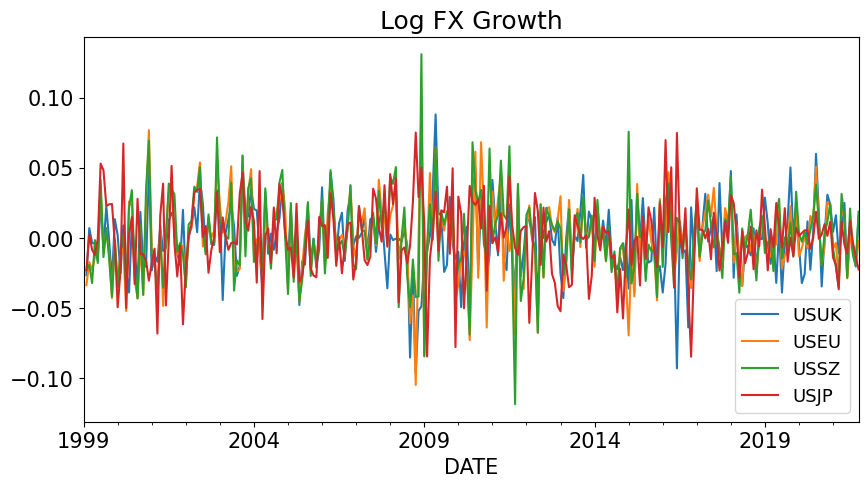

In [10]:
logFXgrowth.plot(title='Log FX Growth', figsize=(10,5));

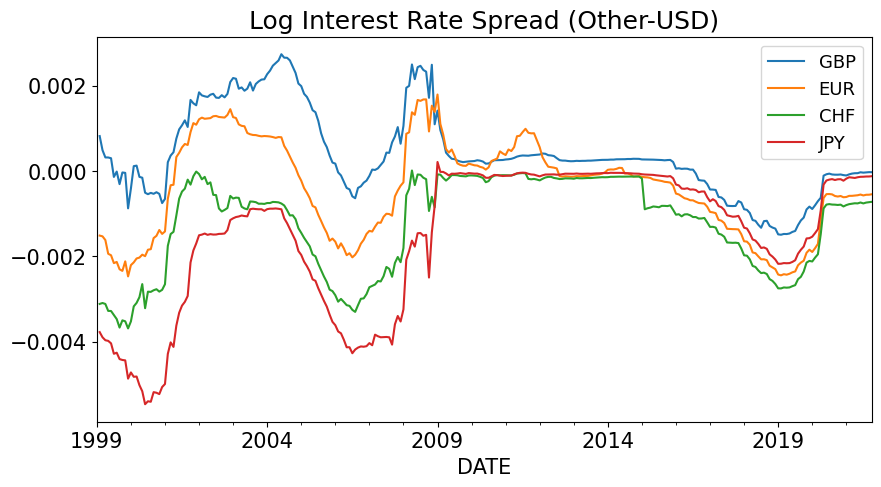

In [11]:
(-logRFspread).plot(title='Log Interest Rate Spread (Other-USD)', figsize=(10,5));

In [12]:
rx_components = logFXgrowth.mean().to_frame()
rx_components.columns=['FX effect']
rx_components['RF effect'] = -logRFspread.mean().values
rx_components['Total'] = rx_components.sum(axis=1)
rx_components *= 12
rx_components.style.format('{:.2%}')

,FX effect,RF effect,Total
USUK,-0.81%,0.46%,-0.35%
USEU,0.07%,-0.50%,-0.44%
USSZ,1.91%,-1.48%,0.43%
USJP,0.08%,-1.82%,-1.74%


***

## Cryptocurrency

## Crypto Data

For a more thorough description of Crypto, see the references below.

Here, we simply look at the data of the 4 largest cryptocurrencies.

In [13]:
LOADFILE = '../data/fx_data.xlsx'
crypto = pd.read_excel(LOADFILE,sheet_name='crypto').set_index('DATE')
crypto

,BTC,ETH,LTC,BCH
DATE,,,,
2017-12-20,16496.89,802.86,305.59,3746.84
2017-12-21,15758.80,796.98,311.00,3162.53
2017-12-22,14210.57,682.11,267.79,2719.99
2017-12-26,15790.88,755.07,280.14,2928.04
2017-12-27,15367.08,739.99,264.40,2719.69
...,...,...,...,...
2024-04-22,66828.83,3200.23,85.47,523.11
2024-04-23,66472.30,3221.28,85.04,505.95
2024-04-24,64198.50,3135.53,83.00,478.15


/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_10380/2676918284.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sns.heatmap(currency.resample('M').last().pct_change().corr(),annot=True);


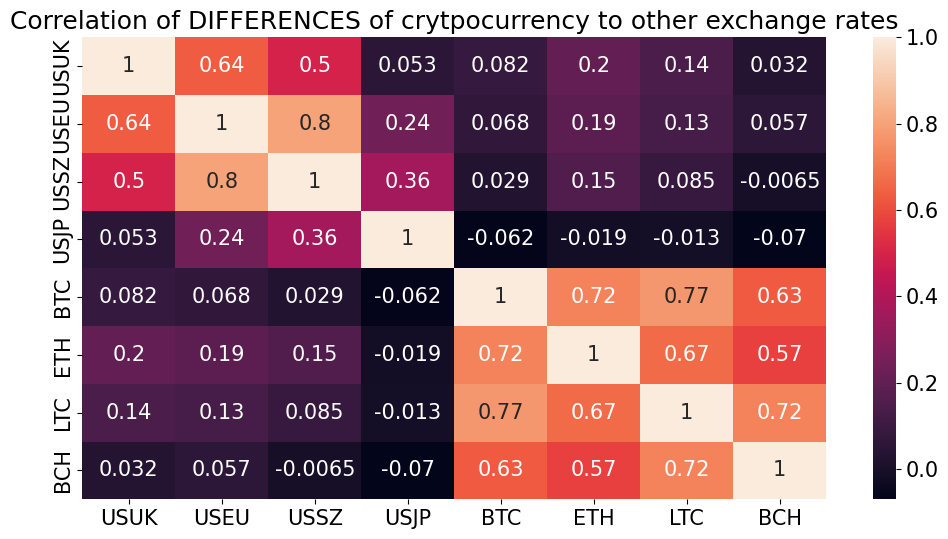

In [14]:
currency = pd.concat([fx,crypto],axis=1)

sns.heatmap(currency.resample('M').last().pct_change().corr(),annot=True);
plt.title('Correlation of DIFFERENCES of crytpocurrency to other exchange rates');

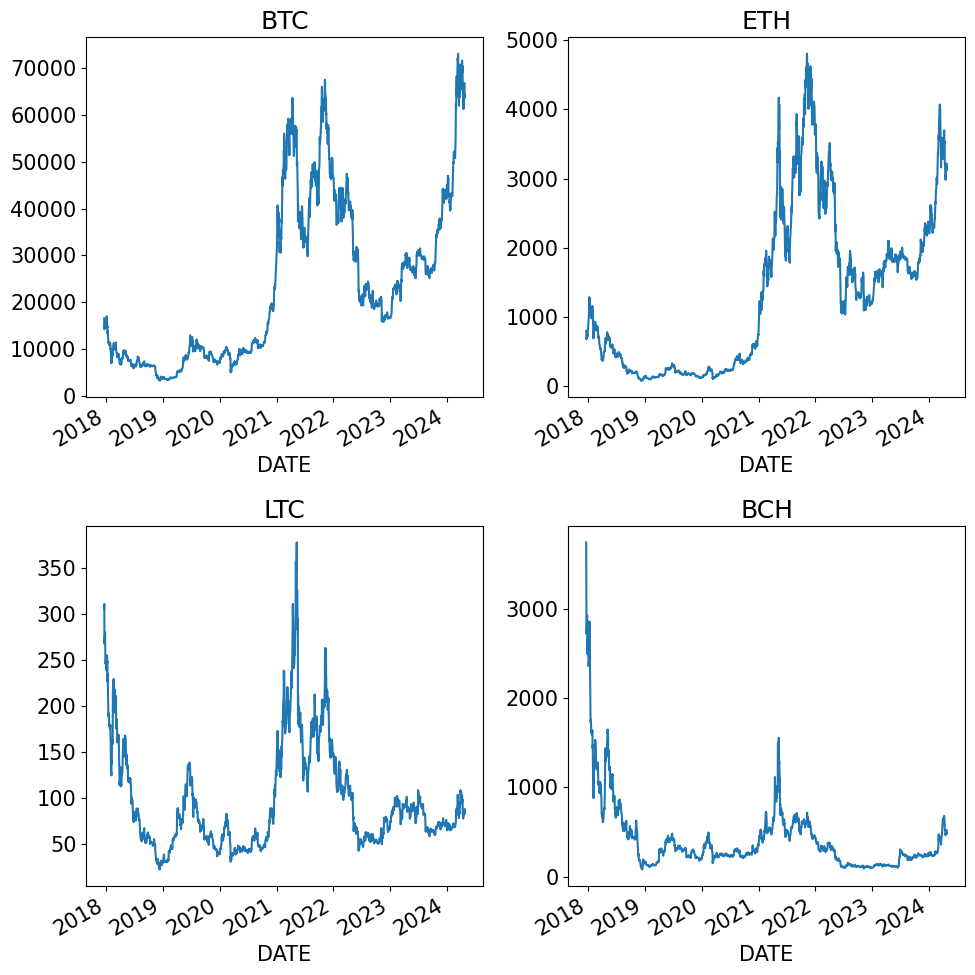

In [15]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i, col in enumerate(crypto.columns):
    crypto[col].plot(ax=ax[int(i/2),i%2], title=col)

plt.tight_layout()
plt.show()

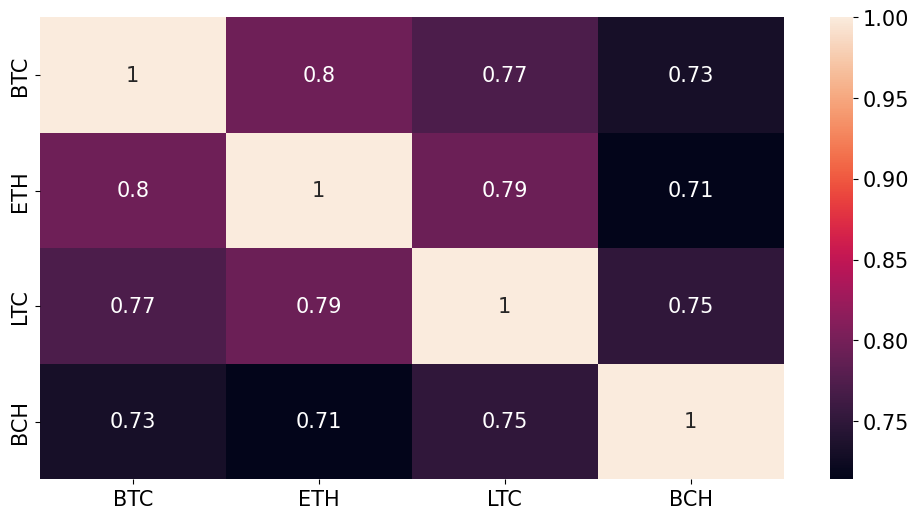

In [16]:
sns.heatmap(crypto.pct_change().corr(),annot=True);

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_10380/94748999.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (currency.pct_change().std()*ANNUALIZE).plot.bar(title='Volatility of Exchange Rate Changes');


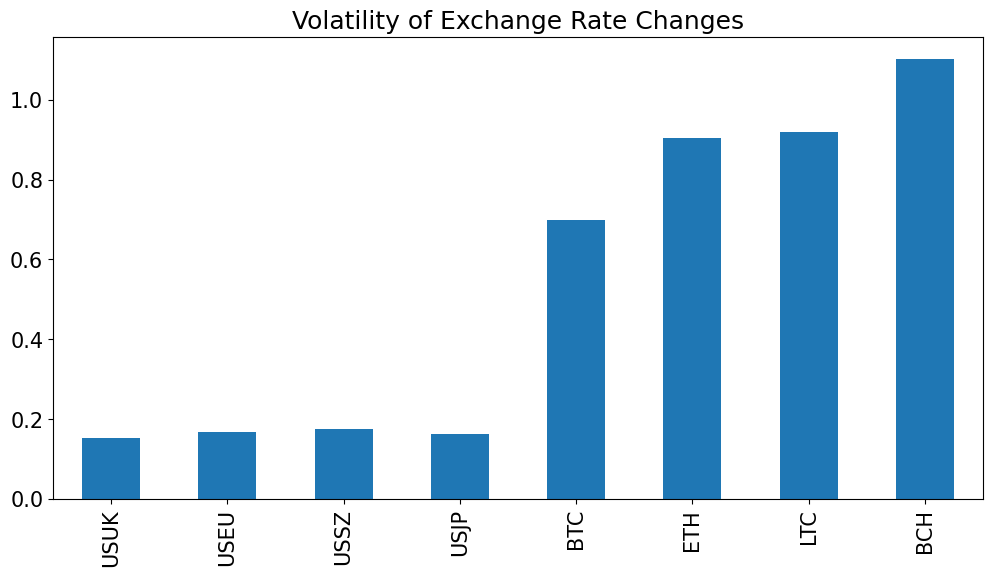

In [17]:
ANNUALIZE= np.sqrt(252)
(currency.pct_change().std()*ANNUALIZE).plot.bar(title='Volatility of Exchange Rate Changes');

## References


#### Economics of Crytpo

Recommend this textbook chapter (published freely)

https://marginalrevolution.com/wp-content/uploads/2022/05/Cryptoeconomics-Modern-Principles.pdf

#### Blockchain

Highly recommend this video

https://www.youtube.com/watch?v=bBC-nXj3Ng4


#### Explore the blockchain
https://www.blockchain.com/explorer

#### Cryptographic security
https://www.youtube.com/watch?v=S9JGmA5_unY